# 1. Importar librerías  
En esta sección importamos todas las dependencias necesarias para manipulación de datos, visualización, selección de características, reducción de dimensionalidad y modelado.

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 2. Carga de datos  
Leemos el fichero CSV con los datos de accidentes de tráfico y mostramos un resumen inicial de la tabla.

In [ ]:
df = pd.read_parquet('/content/accidentes_trafico_final.parquet')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97916 entries, 0 to 97915
Data columns (total 77 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID_ACCIDENTE              97916 non-null  int64  
 1   ANYO                      97916 non-null  int64  
 2   MES                       97916 non-null  int64  
 3   DIA_SEMANA                97916 non-null  int64  
 4   HORA                      97916 non-null  int64  
 5   COD_PROVINCIA             97916 non-null  int64  
 6   COD_MUNICIPIO             97916 non-null  int64  
 7   ISLA                      5207 non-null   float64
 8   ZONA                      97916 non-null  int64  
 9   ZONA_AGRUPADA             97916 non-null  int64  
 10  CARRETERA                 97916 non-null  object 
 11  KM                        50944 non-null  float64
 12  SENTIDO_1F                97916 non-null  int64  
 13  TITULARIDAD_VIA           97916 non-null  int64  
 14  TIPO_V

# 3. Definición de la variable objetivo  
Creamos `NUM_ACCIDENTE_MES` y agrupamos por provincia y mes

In [ ]:
# Calcular el número y porcentaje de nulos
nulos_por_columna = df.isna().sum()
porcentaje_nulos = (nulos_por_columna / len(df)) * 100

# Filtrar solo las columnas con nulos
columnas_con_nulos = nulos_por_columna[nulos_por_columna > 0]
porcentaje_con_nulos = porcentaje_nulos[porcentaje_nulos > 0]

# Mostrar el número de nulos por columna
print("Columnas con número de nulos:")
print(columnas_con_nulos)

# Mostrar el porcentaje de nulos por columna
print("\nColumnas con porcentaje de nulos:")
print(porcentaje_con_nulos)

Columnas con número de nulos:
ISLA                92709
KM                  46972
NUDO_INFO           60207
CARRETERA_CRUCE     95248
CONDICION_NIEBLA    90136
CONDICION_VIENTO    97653
dtype: int64

Columnas con porcentaje de nulos:
ISLA                94.682177
KM                  47.971731
NUDO_INFO           61.488419
CARRETERA_CRUCE     97.275215
CONDICION_NIEBLA    92.054414
CONDICION_VIENTO    99.731402
dtype: float64


In [ ]:
cols = ['TITULARIDAD_VIA', 'NUDO_INFO', 'PRIORI_NORMA', 'PRIORI_AGENTE', 'PRIORI_SEMAFORO', 'PRIORI_VERT_STOP',
        'PRIORI_VERT_CEDA', 'PRIORI_HORIZ_STOP', 'PRIORI_HORIZ_CEDA', 'PRIORI_MARCAS', 'PRIORI_PEA_NO_ELEV',
        'PRIORI_PEA_ELEV', 'PRIORI_MARCA_CICLOS', 'PRIORI_CIRCUNSTANCIAL', 'PRIORI_OTRA','CONDICION_NIVEL_CIRCULA','CONDICION_FIRME',
        'CONDICION_ILUMINACION','CONDICION_METEO','VISIB_RESTRINGIDA_POR','ACERA','TRAZADO_PLANTA'] 
for c in cols:
    df[c] = df[c].replace({998: np.nan, 999: np.nan})

# Verificamos que no haya más nulos
porcentaje_con_nulos = porcentaje_nulos[porcentaje_nulos > 0]
print(porcentaje_con_nulos)

ISLA                94.682177
KM                  47.971731
NUDO_INFO           61.488419
CARRETERA_CRUCE     97.275215
CONDICION_NIEBLA    92.054414
CONDICION_VIENTO    99.731402
dtype: float64


In [ ]:
# Identificar columnas numéricas y categóricas con nulos
columnas_numericas_con_nulos = df.select_dtypes(include=np.number).columns[df.select_dtypes(include=np.number).isnull().any()].tolist()
columnas_categoricas_con_nulos = df.select_dtypes(include='object').columns[df.select_dtypes(include='object').isnull().any()].tolist()

# Reemplazar nulos en columnas numéricas con 0
for col in columnas_numericas_con_nulos:
    df[col] = df[col].fillna(0)

# Reemplazar nulos en columnas categóricas con 'missing'
for col in columnas_categoricas_con_nulos:
    df[col] = df[col].fillna('missing')

# Verificar si aún quedan nulos
nulos_despues = df.isnull().sum().sum()

if nulos_despues == 0:
    print("\nTodos los valores nulos han sido reemplazados.")
else:
    print(f"\nAún quedan {nulos_despues} valores nulos.")
    print(df.isnull().sum()[df.isnull().sum() > 0]) # Mostrar columnas con nulos restantes


Todos los valores nulos han sido reemplazados.


In [ ]:
# Calcular el número y porcentaje de nulos
nulos_por_columna = df.isna().sum()
porcentaje_nulos = (nulos_por_columna / len(df)) * 100

# Filtrar solo las columnas con nulos
columnas_con_nulos = nulos_por_columna[nulos_por_columna > 0]
porcentaje_con_nulos = porcentaje_nulos[porcentaje_nulos > 0]

# Mostrar el número de nulos por columna
print("Columnas con número de nulos:")
print(columnas_con_nulos)

# Mostrar el porcentaje de nulos por columna
print("\nColumnas con porcentaje de nulos:")
print(porcentaje_con_nulos)

Columnas con número de nulos:
Series([], dtype: int64)

Columnas con porcentaje de nulos:
Series([], dtype: float64)


In [ ]:
# Crear columna 'fecha' como primer día de cada mes
df['fecha'] = pd.to_datetime(dict(year=df.ANYO, month=df.MES, day=1))

# 2) Target: contar accidentes por provincia y mes
monthly_counts = (
    df
    .groupby(['COD_PROVINCIA', 'fecha'])
    .size()
    .reset_index(name='NUM_ACCIDENTE_MES')
)

categorical_cols = [
    'CONDICION_METEO',
    'CONDICION_ILUMINACION',
    'CONDICION_NIEBLA',
    'CONDICION_VIENTO',
    'VISIB_RESTRINGIDA_POR',
    'PRIORI_NORMA',
    'PRIORI_AGENTE',
    'PRIORI_MARCAS',
    'PRIORI_PEA_NO_ELEV',
    'PRIORI_PEA_ELEV',
    'PRIORI_MARCA_CICLOS',
    'PRIORI_CIRCUNSTANCIAL',
    'PRIORI_OTRA',
    'CONDICION_NIVEL_CIRCULA',
    'CONDICION_FIRME',
    'ACERA',
    'TRAZADO_PLANTA',
    'TITULARIDAD_VIA',
    'NUDO_INFO',
    'PRIORI_SEMAFORO',
    'PRIORI_VERT_STOP',
    'PRIORI_VERT_CEDA',
    'PRIORI_HORIZ_STOP',
    'PRIORI_HORIZ_CEDA',
    'TIPO_VIA',
    'NUDO'
]

# One-hot encoding y añadir al DataFrame
for col in categorical_cols:
    dummies = pd.get_dummies(
        df[col].fillna(-1),
        prefix=col.lower(),
        prefix_sep='_',
        dtype=float
    )
    df = pd.concat([df, dummies], axis=1)

# Obtener columnas dummy generadas
dummy_cols = [
    c for c in df.columns
    if any(c.startswith(col.lower() + '_') for col in categorical_cols)
]

numeric_cols = [
    'trafico_ligero_estimado',
    'trafico_pesado_estimado',
]

agg_df = (
    df
    .groupby(['COD_PROVINCIA', 'fecha'])[dummy_cols + numeric_cols]
    .mean()
    .reset_index()
)

# Unir todo al dataframe final con el target
df = monthly_counts.merge(agg_df, on=['COD_PROVINCIA', 'fecha'], how='left')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624 entries, 0 to 623
Columns: 127 entries, COD_PROVINCIA to trafico_pesado_estimado
dtypes: datetime64[ns](1), float64(124), int64(2)
memory usage: 619.3 KB


52 provincias x 12 meses = 624 filas

In [ ]:
provincias = df['COD_PROVINCIA'].unique()
fechas = pd.date_range(start=df['fecha'].min(), end=df['fecha'].max(), freq='MS')

multi_index = pd.MultiIndex.from_product([provincias, fechas], names=['COD_PROVINCIA', 'fecha'])

# Reindexamos el dataframe completo
df_full = df.set_index(['COD_PROVINCIA', 'fecha']).reindex(multi_index).reset_index()

# Rellenar valores faltantes
df_full['NUM_ACCIDENTE_MES'] = df_full['NUM_ACCIDENTE_MES'].fillna(0)

df_full.fillna(0, inplace=True)

In [ ]:
def split_data(df, target, test_size=0.3, val_size=0.5, random_state=42):
    train, temp = train_test_split(df, test_size=test_size, random_state=random_state)
    val, test  = train_test_split(temp, test_size=val_size, random_state=random_state)
    return train, val, test

train,val,test = split_data(df_full, 'NUM_ACCIDENTE_MES')
print(f'Tamaño del conjunto de entrenamiento: {train.shape}')
print(f'Tamaño del conjunto de validación: {val.shape}')
print(f'Tamaño del conjunto de prueba: {test.shape}')

Tamaño del conjunto de entrenamiento: (436, 127)
Tamaño del conjunto de validación: (94, 127)
Tamaño del conjunto de prueba: (94, 127)


In [ ]:
X_train = train.drop(columns=['NUM_ACCIDENTE_MES'])
y_train = train['NUM_ACCIDENTE_MES']
X_val = val.drop(columns=['NUM_ACCIDENTE_MES'])
y_val = val['NUM_ACCIDENTE_MES']
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(436, 126)
(436,)
(94, 126)
(94,)


In [ ]:
def create_lstm_sequences(X, y, lookback=6):
    """
    Convierte un dataframe X y una serie y en secuencias para LSTM.

    Args:
        X: pd.DataFrame con características, debe contener columnas 'COD_PROVINCIA' y 'fecha'.
        y: pd.Series o array con el target correspondiente.
        lookback: cantidad de meses previos que la LSTM usará para predecir.

    Retorna:
        X_seq: np.array de forma (n_samples, lookback, n_features)
        y_seq: np.array de forma (n_samples,)
    """
    provincias = X['COD_PROVINCIA'].values
    fechas = X['fecha'].values

    # Excluir columnas no numéricas para el array
    X_numeric = X.drop(columns=['COD_PROVINCIA', 'fecha']).to_numpy()

    X_seq, y_seq = [], []

    for prov in np.unique(provincias):
        idx = np.where(provincias == prov)[0]

        # Ordenar por fecha
        orden_fecha = np.argsort(fechas[idx])
        idx = idx[orden_fecha]

        for i in range(lookback, len(idx)):
            X_seq.append(X_numeric[idx[i - lookback:i], :])
            y_seq.append(y.iloc[idx[i]])

    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)

    return X_seq, y_seq


# Fuera de la función, para llamar:
X_seq, y_seq = create_lstm_sequences(
    X=df_full.drop(columns=['NUM_ACCIDENTE_MES']),
    y=df_full['NUM_ACCIDENTE_MES'],
    lookback=6
)

print(X_seq.shape)
print(y_seq.shape)

(312, 6, 124)
(312,)


# Interactivo

In [ ]:
# Modelo LSTM
class LSTMRegressor(nn.Module):
    def __init__(self, n_features, hidden_dim=50, n_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size=n_features,
                            hidden_size=hidden_dim,
                            num_layers=n_layers,
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # x: (batch, seq_len, n_features)
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        return self.fc(last)

# Preparar y entrenar para una provincia
def predict_province(df, prov_code, lookback=6, epochs=50, batch_size=16, lr=1e-3):
    # Filtrar datos de la provincia
    dfp = df[df['COD_PROVINCIA']==prov_code].sort_values('fecha').reset_index(drop=True)
    if len(dfp) < lookback+1:
        raise ValueError(f"Pocos datos para lookback={lookback} en provincia {prov_code}")

    # Crear secuencias
    X, y = dfp.drop(columns=['COD_PROVINCIA','fecha','NUM_ACCIDENTE_MES']).values, dfp['NUM_ACCIDENTE_MES'].values
    X_seq, y_seq = [], []
    for i in range(lookback, len(X)):
        X_seq.append(X[i-lookback:i])
        y_seq.append(y[i])
    X_seq = np.stack(X_seq)
    y_seq = np.array(y_seq)

    # Escalar
    n_samples, seq_len, n_feat = X_seq.shape
    scaler_X = MinMaxScaler()
    X_flat = X_seq.reshape(-1, n_feat)
    X_scaled = scaler_X.fit_transform(X_flat).reshape(n_samples, seq_len, n_feat)
    scaler_y = MinMaxScaler()
    y_scaled = scaler_y.fit_transform(y_seq.reshape(-1,1)).flatten()

    # Tensores y DataLoader
    X_t = torch.tensor(X_scaled, dtype=torch.float32)
    y_t = torch.tensor(y_scaled, dtype=torch.float32).unsqueeze(1)
    loader = DataLoader(TensorDataset(X_t, y_t), batch_size=batch_size, shuffle=True)

    # Modelo, loss y optimizador
    model = LSTMRegressor(n_feat).to('cpu')
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Entrenamiento
    for epoch in range(1, epochs+1):
        model.train()
        total_loss = 0.0
        for xb, yb in loader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * xb.size(0)
        if epoch % 10 == 0 or epoch == 1:
            print(f"Epoch {epoch}/{epochs} — Loss: {total_loss/len(loader.dataset):.4f}")

    # Predicción para el siguiente mes
    model.eval()
    with torch.no_grad():
        last_window = X_t[-1].unsqueeze(0)    # forma (1, lookback, n_feat)
        pred_scaled = model(last_window).cpu().numpy()
    return scaler_y.inverse_transform(pred_scaled)[0,0]

In [ ]:
# Mapeo oficial INE de 1 a 52, y 51=Ceuta, 52=Melilla
code_to_name = {
    1: "Álava", 2: "Albacete", 3: "Alicante", 4: "Almería", 5: "Ávila",
    6: "Badajoz", 7: "Islas Baleares", 8: "Barcelona", 9: "Burgos",
    10: "Cáceres", 11: "Cádiz", 12: "Castellón", 13: "Ciudad Real",
    14: "Córdoba", 15: "A Coruña", 16: "Cuenca", 17: "Girona",
    18: "Granada", 19: "Guadalajara", 20: "Guipúzcoa", 21: "Huelva",
    22: "Huesca", 23: "Jaén", 24: "León", 25: "Lleida", 26: "La Rioja",
    27: "Lugo", 28: "Madrid", 29: "Málaga", 30: "Murcia", 31: "Navarra",
    32: "Ourense", 33: "Asturias", 34: "Palencia", 35: "Las Palmas",
    36: "Pontevedra", 37: "Salamanca", 38: "Santa Cruz de Tenerife",
    39: "Cantabria", 40: "Segovia", 41: "Sevilla", 42: "Soria",
    43: "Tarragona", 44: "Teruel", 45: "Toledo", 46: "Valencia",
    47: "Valladolid", 48: "Vizcaya", 49: "Zamora", 50: "Zaragoza",
    51: "Ceuta", 52: "Melilla"
}
# Invertimos para nombre → código, normalizando a minúsculas
name_to_code = {name.casefold(): code for code, name in code_to_name.items()}

### Predicción de accidentes mensuales por provincia ###
Teclea el nombre exacto de la provincia (e.g. 'A Coruña'), o 'salir' para terminar.

Provincia: A Coruña
Epoch 1/50 — Loss: 0.3460
Epoch 10/50 — Loss: 0.1225
Epoch 20/50 — Loss: 0.0626
Epoch 30/50 — Loss: 0.0284
Epoch 40/50 — Loss: 0.0110
Epoch 50/50 — Loss: 0.0034


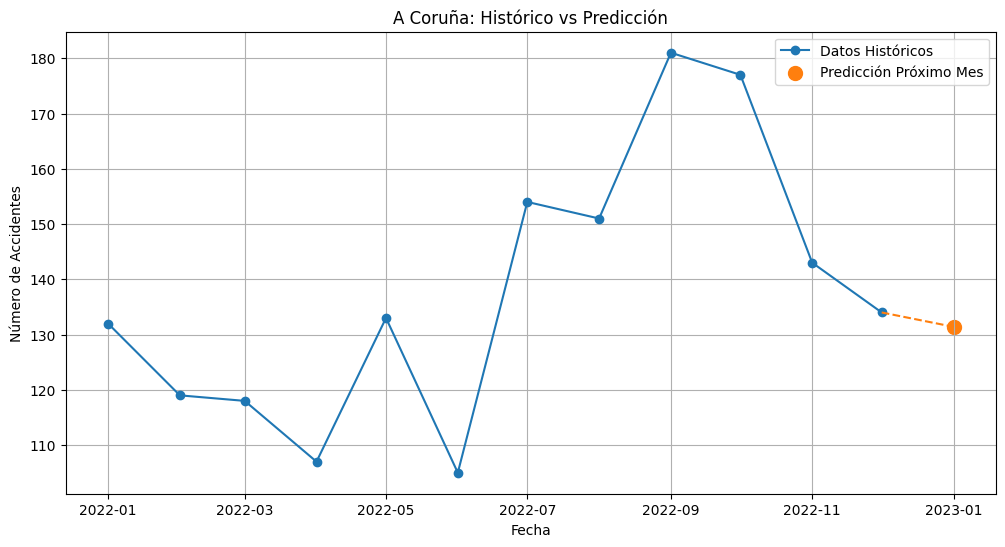

→ Próximo mes (2023-01-01) en A Coruña: 131 accidentes

Provincia: Madrid
Epoch 1/50 — Loss: 0.5742
Epoch 10/50 — Loss: 0.1246
Epoch 20/50 — Loss: 0.0616
Epoch 30/50 — Loss: 0.0430
Epoch 40/50 — Loss: 0.0240
Epoch 50/50 — Loss: 0.0126


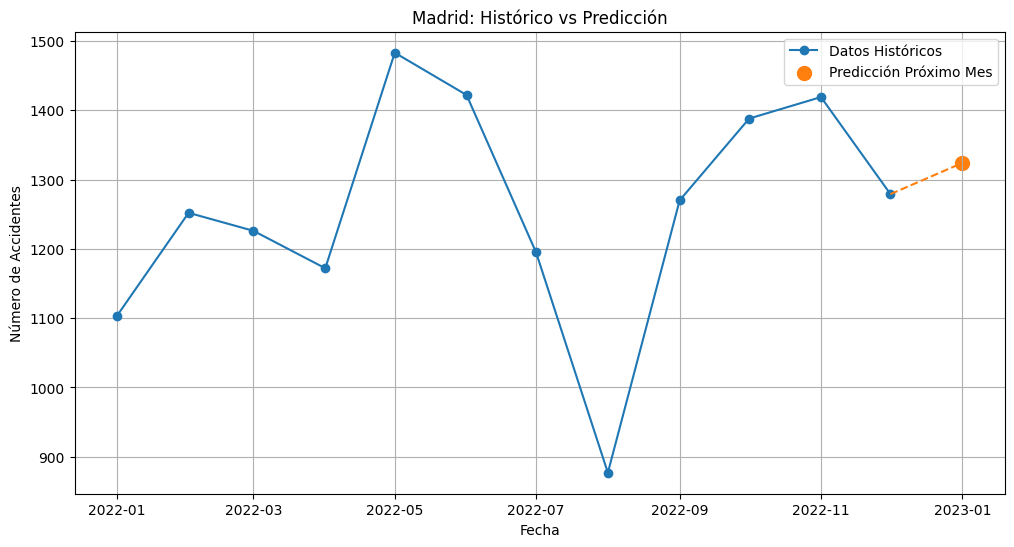

→ Próximo mes (2023-01-01) en Madrid: 1324 accidentes

Provincia: salir
Saliendo.


In [ ]:
def interactive_predict_by_name(df, lookback=6):
    print("### Predicción de accidentes mensuales por provincia ###")
    print("Teclea el nombre exacto de la provincia (e.g. 'A Coruña'), o 'salir' para terminar.\n")
    while True:
        entrada = input("Provincia: ").strip()
        if entrada.casefold() in ("salir", "exit", "quit"):
            print("Saliendo."); break

        key = entrada.casefold()
        if key not in name_to_code:
            print("→ Provincia no encontrada. Revisa la ortografía.\n")
            continue
        code = name_to_code[key]

        # Filtrar y ordenar
        dfp = df[df['COD_PROVINCIA']==code].sort_values('fecha').reset_index(drop=True)
        if len(dfp) < lookback+1:
            print(f"→ Pocos datos para lookback={lookback} en {entrada}\n"); continue

        # Serie histórica
        fechas_hist = dfp['fecha']
        y_hist = dfp['NUM_ACCIDENTE_MES'].values

        # Predicción
        pred = predict_province(df, code, lookback=lookback)

        # Fecha siguiente
        next_month = fechas_hist.iloc[-1] + pd.offsets.MonthBegin(1)

        # Gráfico
        plt.figure(figsize=(12,6))
        plt.plot(fechas_hist, y_hist, label='Datos Históricos', marker='o', color='C0')
        plt.scatter([next_month], [pred], color='C1', label='Predicción Próximo Mes', s=100)
        plt.plot(
            [fechas_hist.iloc[-1], next_month],
            [y_hist[-1], pred],
            linestyle='--',
            color='C1'
        )
        plt.title(f'{entrada}: Histórico vs Predicción')
        plt.xlabel('Fecha')
        plt.ylabel('Número de Accidentes')
        plt.legend()
        plt.grid(True)
        plt.show(block=False)
        plt.pause(0.1)
        plt.close()

        print(f"→ Próximo mes ({next_month.date()}) en {entrada}: {pred:.0f} accidentes\n")

# Ejecutar usando df_monthly, NO df_full ---
interactive_predict_by_name(df_full, lookback=6)